<a href="https://colab.research.google.com/github/zhkfei-wq/810/blob/main/Lab4_classifier_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab4: Evaluating Classifiers Using Costs

In Lab 3 we saw how to build a simple pipeline to train classifiers and evaluated them on a test data using many common metrics (accuracy, precision, recall, ROC curve, etc.).

In this lab, we'll improve our evaluations and predictions by

1. Using cross validation
1. Using different costs for different errors
1. Optimizing predictions to minimize the expected costs

The overall goal remains to:
**Develop a classifier to predict if a credit card account will default.**



# Load and split data

Let's load the dataset and quickly examine it:

In [ ]:
import pandas as pd
data_url = 'https://drive.google.com/uc?export=download&id=13bQQfKDjiuBA1njsvCEW81c4Q2huRE9z'
data = pd.read_csv(data_url)
print('High level data description:')
data.info()
print('\nFirst 3 rows:')
data.head(3)

High level data description:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB

First 3 rows:


,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947


Let's set aside some data for testing so that we can estimate the generalization error.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X = data.drop("default", axis=1)
y = data["default"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

And create the full pipeline below as we did in Lab 3.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

from sklearn import set_config
set_config(display='diagram') # shows the pipeline structure graphically

cat_attribs = ["student"]
num_attribs = ["balance", "income"]

preprocess_pipeline = ColumnTransformer([ # handle each type of column with appropriate pipeline
        ("cat", OneHotEncoder(drop="first"), cat_attribs),
        ("num", StandardScaler(), num_attribs),
    ])

lr_pipe = make_pipeline(preprocess_pipeline, LogisticRegression())

# Compare multiple classifiers

In the last lab we used test data to evaluate and select among multiple classifiers. While better than comparing based on training data error, it has at least two drawbacks:

1. Evaluation is done on a small subset of the dataset thus can vary quite a bit from one random train-test split to next.
1. By using the test data for selecting a model, then we can't use it to estimate generalization error -- the performance of the selected model on this test set is likely to be better than what we can expect on new data in the future.

A better way to evaluate and select models that overcomes both these challenges is cross-validation within the *training data*.

Note: this doesn't use test data, but splits up training data and uses their folds for training and validation. Each method is evaluated on every record in our training data (when that record is in the test fold). Thus the evaluation is likely to be more stable. After we have selected a model based on cross validation average, we can estimate its generalization error on the test data that we set aside at the beginning.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

lr_scores = cross_val_score(lr_pipe, X_train, y_train, cv=5, scoring='balanced_accuracy')
  # we continue to use balanced accuracy from last time as it's a skewed dataset.
print(f'The balanced accuracy of Logistic Regression is {lr_scores.mean():.3f}.')

knn_pipe = make_pipeline(preprocess_pipeline, KNeighborsClassifier(n_neighbors=5))
knn_scores = cross_val_score(knn_pipe, X_train, y_train, cv=5, scoring='balanced_accuracy')
print(f'The balanced accuracy of K Nearest Neighbor is {knn_scores.mean():.3f}.')

rf_pipe = make_pipeline(preprocess_pipeline, RandomForestClassifier(n_estimators=100, random_state=42))
rf_scores = cross_val_score(rf_pipe, X_train, y_train, cv=5, scoring='balanced_accuracy')
print(f'The balanced accuracy of Random Forest is {rf_scores.mean():.3f}.')

The balanced accuracy of Logistic Regression is 0.642.
The balanced accuracy of K Nearest Neighbor is 0.634.
The balanced accuracy of Random Forest is 0.652.


***

#Pick Cheapest Model by Applying Cost Matrix

Which model has the highest balanced accuracy?

Now, suppose we have the costs of making false positive and false negative mistakes -- and it's five times more costly to mistake a Default for Non-default than the other way.

| Cost matrix    | **Predicted -** | **Predicted +** |
|----------------|-----------------|-----------------|
| **Actual -**   | 0               | 1               |
| **Actual +**   | 5               | 0               |



If we have these data, we no longer primarily care about accuracy, balance accuracy, Area under the ROC, and other such cost-free metrics.
At the end of the day, we want to minimize the expected cost of using the classifier.

We incorporate these costs into our evaluation by defining a custom scoring function (that gives the cost of a prediction) to use instead of the balanced accuracy.

In [ ]:
from sklearn.metrics import make_scorer, confusion_matrix

def default_cost(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred, labels = ['No', 'Yes'])
    # labels .. guarantees that 0'th class is No and 1st is Yes. Else, order in which found in data.
  return cm[1,0] * 5 + cm[0,1] * 1
  # return total FN costs + total FP costs

# we can directly use default_cost() method to evaluate prediction, but to use inside
# cross-validation, we need to wrap this inside a scorer object:
cost_scorer = make_scorer(default_cost)

Like any other scorer the `cost_scorer` is a python object that can be used on its own to measure the cost of prediction on a test data (instead of, say `balanced_accuracy_score` of prediction):

In [ ]:
rf_pipe.fit(X_train, y_train)
print(f'The cost of Random Forest on the test data is {cost_scorer(rf_pipe, X_test, y_test)}.')

The cost of Random Forest on the test data is 333.


But often we'd pass it to other wrapper methods, like `cross_val_score` below:

In [ ]:
rf_costs = cross_val_score(rf_pipe, X_train, y_train, cv=5, scoring=cost_scorer)
print(f'The average cost of Random Forest is {rf_costs.mean():.1f}.')

The average cost of Random Forest is 174.8.


***
**Exercise**

Let's take 5mins, pair with a neighbor to ...

*Select a classifier among the ones we have considered so far in this notebook that leads to lowest expected cost of misclassification.*

***

### Exercise Solution <font color='red'>(try yourself first)</font>


In [ ]:
#@title Costs of Logistic Regression and k-NN (<font color='crimson'>try first</font>)

lr_costs = cross_val_score(lr_pipe, X_train, y_train, cv=5, scoring=cost_scorer)
print(f'The average cost of Logistic Regression is {lr_costs.mean():.1f}.')

knn_costs = cross_val_score(knn_pipe, X_train, y_train, cv=5, scoring=cost_scorer)
print(f'The average cost of k-Nearest Neighbor is {knn_costs.mean():.1f}.')

The average cost of Logistic Regression is 174.6.
The average cost of k-Nearest Neighbor is 181.4.


Given these we might prefer Logistic Regression, although performance of Random Forest is very close.

Recall from the exercise at the end of Lab 3 that Random Forest had the highest balanced accuracy -- shows that the one with highest accuracy/balanced-accuracy need not be cheapest.

## Choose the threshold to minimize cost

In the previous block we chose a classifier that minimizes the cost of operation *under its default mode of prediction*: if the probability of default is greater than 0.5, it predicted postive; otherwise, it predicted negative. That it is five times more costly to predict "won't default" when a default happens, wasn't considered in our *prediction* step. We simply used the cost matrix later to conclude that the most accurate may not be the cheapest after all.

As we saw in the class 4, if the two types of errors have different costs, we may be able to lower the cost of prediction, by choosing a different threshold than 0.5. In this case, since it's more costly to make a false negative mistake, we should be reluctant to flag something as negative, unless we are confident that it's negative, i.e., the probability of being positive is low (potentially lower than 0.5). Let's carry out that exercise in python now.

**Task**: Find the optimum positive-probability threshold to minimize the cost of misclassification.


Let's start by checking the cost of using the best model obtained so far to predict on the test set (that we set aside at the beginning) under the default model of prediction.

In [ ]:
model = lr_pipe.fit(X_train, y_train)
print('The cost under standard prediction strategy is %d.' % default_cost(y_test, model.predict(X_test)))

The cost under standard prediction strategy is 337.


Can we further improve cost simply by tuning its threshold? What should be the threshold and what cost can we expect?

The scikit-learn class `TunedThresholdClassifierCV` takes a model, a cost/benefit scorer, and helps us achieve this using the following steps:

1. Inside K-fold cross validation, for each CV split,
    1. Fit the model to training data and apply the fitted model on test records to estimate their probability of being positive.
    1. for each threshold (e.g., 0, 0.01, ..., 0.99, 1) declare test records above as positive, below as negative, and compute the score using the passed scorer object.
1. For each threshold, average the scores across the K splits.
1. Pick the threshold with the highest score; retrain another model on the entire training data; on it `predict()` uses the best found threshold to predict using this final fitted model.

In [ ]:
from sklearn.model_selection import TunedThresholdClassifierCV
from sklearn.metrics import make_scorer, confusion_matrix

# Define a "benefit_scorer" since the sklearn tuning maximizes a score
benefit_scorer = make_scorer(default_cost, greater_is_better=False)
  # greater_is_better=False multiplies a -1 so that maximizing actually minimizes cost.

# Create an instance of TunedThresholdClassifierCV and fit() to tune
tuned_threshold_model = TunedThresholdClassifierCV(lr_pipe, scoring=benefit_scorer, store_cv_results=True)
tuned_threshold_model.fit(X_train, y_train)

cost_after_tuning = default_cost(y_test, tuned_threshold_model.predict(X_test))
print(f'The cost after tuning the threshold is {cost_after_tuning}.')
print(f'The optimal threshold found by TunedThresholdClassifierCV is {tuned_threshold_model.best_threshold_:.2f}.')

The cost after tuning the threshold is 252.
The optimal threshold found by TunedThresholdClassifierCV is 0.17.


What did we find?

If we take the best found model and apply it as-is to the test data, it'll incur 337 in cost. But, if we tune its threshold — specifically, lower it (from the default of 0.5) to 0.17 — the cost of misclassification will reduce to 254.

By the way, note this threshold is quite close to what we'd have obtained by equating the expected cost of False Positive and that of False Negative. This strategy would have led us to a threshold of $1/(1+5)=1/6 ≈ 0.17$ (recall our calculation from Lecture 4, see `Slides/Lecture4_QuizAnswers.pdf`).

This illustrates that by considering the asymmetric costs of incorrect (and potential benefits of correct) predictions, we can get a learnt model to predict in a way that minimizes the cost (or maximizes the benefits).

The following code illustrates how the cost changes as we change the threshold, with the threhsold for minimum cost.

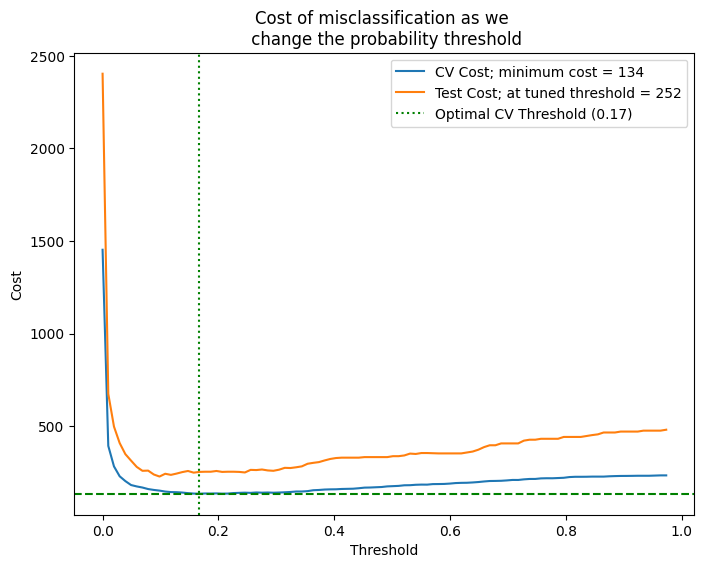

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import FixedThresholdClassifier
from sklearn.frozen import FrozenEstimator

thresholds = tuned_threshold_model.cv_results_["thresholds"]
cv_scores = -tuned_threshold_model.cv_results_["scores"]

# Find the threshold with the minimum cost for plotting purposes
ix = np.argmin(cv_scores)
opt_thresh = thresholds[ix]
min_cost = cv_scores[ix]

frozen_lr_pipe = FrozenEstimator(lr_pipe.fit(X_train, y_train))

# Calculate costs for each threshold using FixedThresholdClassifier with the frozen estimator on the TEST data
test_scores = [
    default_cost(y_test, FixedThresholdClassifier(estimator=frozen_lr_pipe, threshold=t).predict(X_test))
    for t in thresholds
]

# Find the threshold with the minimum cost for plotting purposes (using CV scores)
ix = np.argmin(cv_scores)
opt_thresh_cv = thresholds[ix]
min_cost_cv = cv_scores[ix]
opt_cost_test = test_scores[ix]

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(thresholds, cv_scores, label=f'CV Cost; minimum cost = {min_cost_cv:.0f}');
plt.plot(thresholds, test_scores, label=f'Test Cost; at tuned threshold = {opt_cost_test:.0f}');

plt.axvline(opt_thresh_cv, 0, 1, ls=':', color='green', label=f'Optimal CV Threshold ({opt_thresh_cv:.2f})')
plt.axhline(min_cost_cv, xmin=0, xmax=1, ls='--', color='green')

plt.xlabel('Threshold');
plt.ylabel("Cost");
plt.title('Cost of misclassification as we \n change the probability threshold');
plt.legend()
plt.show()


***
**Exercise**

1. Suppose we have costs for mistakes and *benefits* for correct predictions as shown below:

|             | Not default | Default |
| ----------- | ----------- | ------- |
| Not default |  0          | -1      |
| Default     |  -5         |  5      |

where, the negative numbers refer to cost and positive number to benefit.

Replace the `default_cost()` method by a method, call it `prediction_benefits()`, to incorporate them.

2. Alter the previous code block to select prediction threshold to *maximize benefit*.

- What was the benefit (on the test data) of the default strategy (using threshold 0.5)?
- What can it be improved to by tuning the threshold? What was the threshold? What was the benefit on the cross validation set?

***